In [7]:
!mkdir -p /content/DB
for s in range(1, 8):
    for e in range(1, 4):
        url = f"https://github.com/ali-mohamadpour/EMG-Gesture-Recognition-Analysis/raw/main/DB1/S{s}_A1_E{e}.mat"
        out = f"/content/DB/S{s}_A1_E{e}.mat"
        print("Downloading:", out)
        !wget -q -O $out $url

Downloading: /content/DB/S1_A1_E1.mat
Downloading: /content/DB/S1_A1_E2.mat
Downloading: /content/DB/S1_A1_E3.mat
Downloading: /content/DB/S2_A1_E1.mat
Downloading: /content/DB/S2_A1_E2.mat
Downloading: /content/DB/S2_A1_E3.mat
Downloading: /content/DB/S3_A1_E1.mat
Downloading: /content/DB/S3_A1_E2.mat
Downloading: /content/DB/S3_A1_E3.mat
Downloading: /content/DB/S4_A1_E1.mat
Downloading: /content/DB/S4_A1_E2.mat
Downloading: /content/DB/S4_A1_E3.mat
Downloading: /content/DB/S5_A1_E1.mat
Downloading: /content/DB/S5_A1_E2.mat
Downloading: /content/DB/S5_A1_E3.mat
Downloading: /content/DB/S6_A1_E1.mat
Downloading: /content/DB/S6_A1_E2.mat
Downloading: /content/DB/S6_A1_E3.mat
Downloading: /content/DB/S7_A1_E1.mat
Downloading: /content/DB/S7_A1_E2.mat
Downloading: /content/DB/S7_A1_E3.mat


In [8]:
import glob
import numpy as np
from scipy.io import loadmat
subjects = ['S1','S2','S3','S4','S5','S6','S7']
X_all = []
y_all = []
sub_all = []
for sub in subjects:
    files = glob.glob(f'/content/DB/{sub}_A1_E*.mat')
    for f in files:
        data = loadmat(f)
        emg = data['emg']
        gesture = data['stimulus']
        X_all.append(emg)
        y_all.append(gesture)
        sub_all.append(np.full(gesture.shape, sub))
emg_all = np.vstack(X_all)
gesture_all = np.vstack(y_all)
subject_all = np.vstack(sub_all)


In [9]:
from scipy.signal import butter, filtfilt
fs = 200
def bandpass_filter(signal, fs, low=20, high=45, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal, axis=0)
emg_filt = bandpass_filter(emg_all, fs)
window_size = int(0.2 * fs)
step_size = int(0.1 * fs)


In [10]:
import numpy as np
def extract_features(X):
    feats = []
    for seg in X:
        MAV = np.mean(np.abs(seg), axis=0)
        RMS = np.sqrt(np.mean(seg**2, axis=0))
        WL  = np.sum(np.abs(np.diff(seg, axis=0)), axis=0)
        ZC  = np.sum((seg[:-1] * seg[1:]) < 0, axis=0)
        feat_vec = np.concatenate([MAV, RMS, WL, ZC])
        feats.append(feat_vec)
    return np.array(feats)
def segment_signal_with_subject(emg, labels, subjects, win, step):
    X, y, s = [], [], []
    for i in range(0, emg.shape[0] - win, step):
        seg_label = labels[i:i+win]
        seg_sub   = subjects[i:i+win]
        if np.all(seg_label == seg_label[0]) and np.all(seg_sub == seg_sub[0]):
            X.append(emg[i:i+win, :])
            y.append(seg_label[0])
            s.append(seg_sub[0])

    return np.array(X), np.array(y), np.array(s)

X_seg_all, y_seg_all, subject_seg_all = segment_signal_with_subject(
    emg_all,
    gesture_all.ravel(),
    subject_all.ravel(),
    window_size,
    step_size
)

X_feat_all = extract_features(X_seg_all)

X = X_feat_all
y = y_seg_all.ravel()
subjects = subject_seg_all.ravel()


In [11]:
def mav(x): return np.mean(np.abs(x))
def rms(x): return np.sqrt(np.mean(x**2))
def wl(x): return np.sum(np.abs(np.diff(x)))
def zc(x, th=0.01): return np.sum(np.abs(np.diff(np.sign(x))) > th)
def extract_features(X):
    feats = []
    for w in X:
        f = []
        for ch in range(w.shape[1]):
            sig = w[:, ch]
            f.extend([mav(sig), rms(sig), wl(sig), zc(sig)])
        feats.append(f)
    return np.array(feats)
X_feat_all = extract_features(X_seg_all)


Processing Subject S1
Train samples: 126456
Test samples : 21535


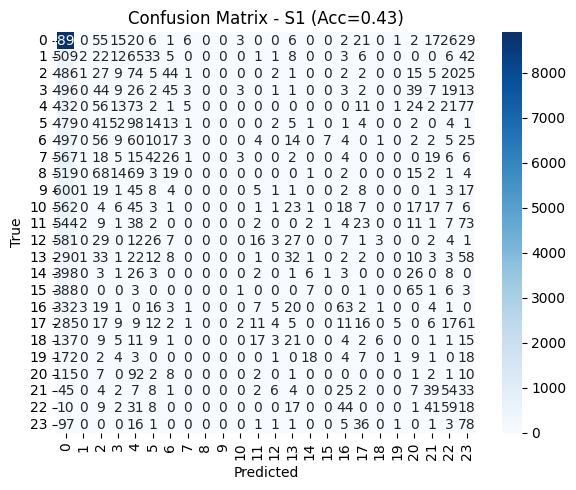

Accuracy for Subject S1: 0.43

Processing Subject S2
Train samples: 126386
Test samples : 21605


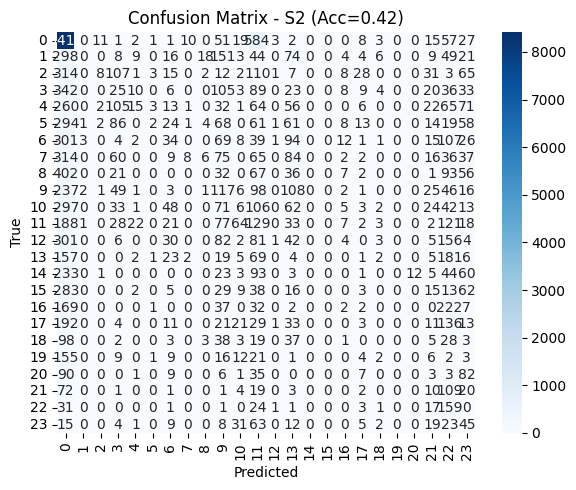

Accuracy for Subject S2: 0.42

Processing Subject S3
Train samples: 126632
Test samples : 21359


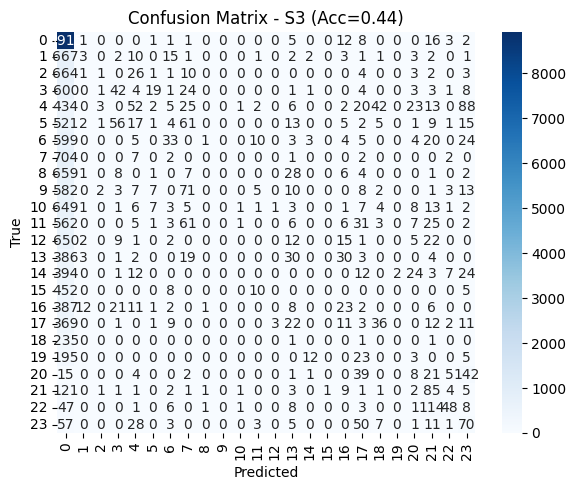

Accuracy for Subject S3: 0.44

Processing Subject S4
Train samples: 127224
Test samples : 20767


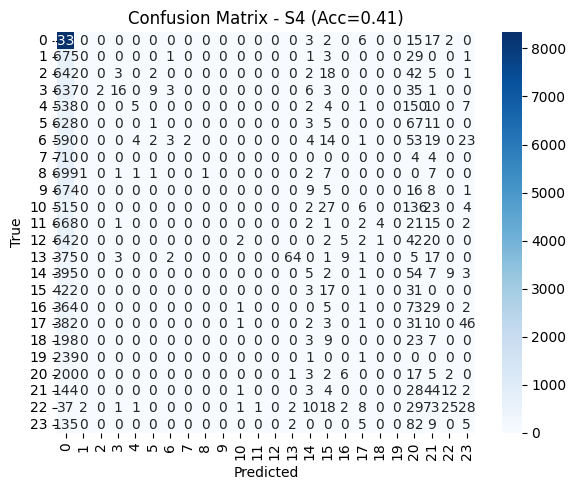

Accuracy for Subject S4: 0.41

Processing Subject S5
Train samples: 127143
Test samples : 20848


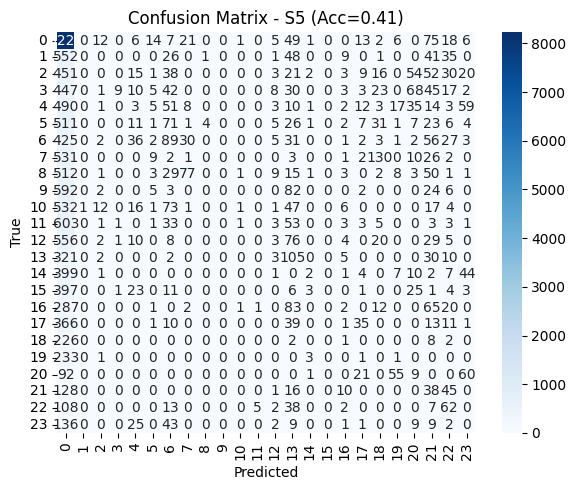

Accuracy for Subject S5: 0.41

Processing Subject S6
Train samples: 127361
Test samples : 20630


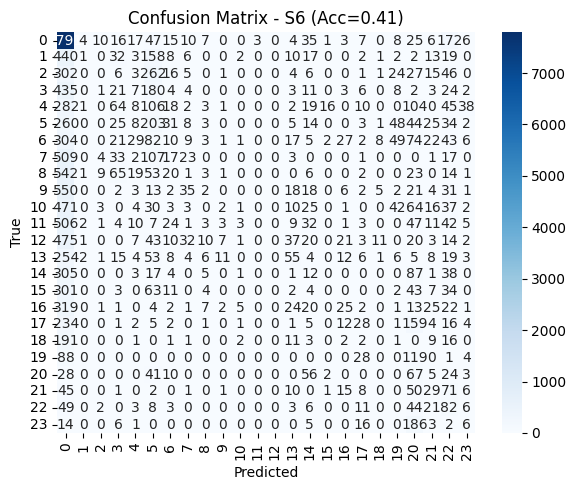

Accuracy for Subject S6: 0.41

Processing Subject S7
Train samples: 126744
Test samples : 21247


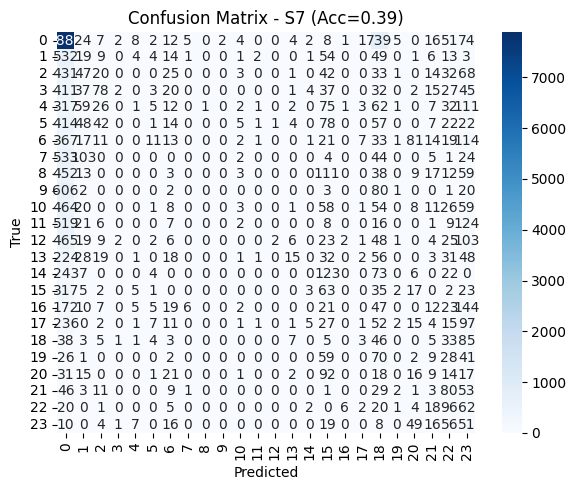

Accuracy for Subject S7: 0.39

Average Accuracy: 0.4145411017049962
Std Deviation   : 0.015397003338632411


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
subjects_1d = subject_seg_all.ravel()
labels_1d   = y_seg_all.ravel()
unique_subjects = np.unique(subjects_1d)
acc_list = []
for sub in unique_subjects:
    print(f"\nProcessing Subject {sub}")
    test_idx  = subjects_1d == sub
    train_idx = subjects_1d != sub
    X_train = X_feat_all[train_idx]
    y_train = labels_1d[train_idx]
    X_test  = X_feat_all[test_idx]
    y_test  = labels_1d[test_idx]
    print("Train samples:", X_train.shape[0])
    print("Test samples :", X_test.shape[0])
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {sub} (Acc={acc:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    print(f"Accuracy for Subject {sub}: {acc:.2f}")
print("\n============================")
print("Average Accuracy:", np.mean(acc_list))
print("Std Deviation   :", np.std(acc_list))


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1.0)
from sklearn.metrics import accuracy_score
X = X_feat_all
y = y_seg_all.ravel()
subjects = subject_seg_all.ravel()
print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("subjects:", subjects.shape)
unique_subjects = np.unique(subjects)
print("Unique subjects:", unique_subjects)

acc_list = []
for sub in unique_subjects:
    print(f"\nProcessing Subject {sub} ...")

    test_idx  = (subjects == sub)
    train_idx = (subjects != sub)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test  = X[test_idx]
    y_test  = y[test_idx]

    print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

    if X_test.shape[0] == 0:
        print("No samples → skipped")
        continue

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    svm = LinearSVC(C=1.0, max_iter=5000)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    print(f"Accuracy for Subject {sub}: {acc:.2f}")
acc_list = np.array(acc_list)

print("\n==============================")
print(f"Average Accuracy: {acc_list.mean():.2f}")
print(f"Std: {acc_list.std():.2f}")
print("==============================")


Shapes:
X: (147991, 40)
y: (147991,)
subjects: (147991,)
Unique subjects: ['S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7']

Processing Subject S1 ...
Train: 126456 | Test: 21535
Accuracy for Subject S1: 0.44

Processing Subject S2 ...
Train: 126386 | Test: 21605
Accuracy for Subject S2: 0.44

Processing Subject S3 ...
Train: 126632 | Test: 21359
Accuracy for Subject S3: 0.44

Processing Subject S4 ...
Train: 127224 | Test: 20767
Accuracy for Subject S4: 0.41

Processing Subject S5 ...
Train: 127143 | Test: 20848
Accuracy for Subject S5: 0.41

Processing Subject S6 ...
Train: 127361 | Test: 20630
Accuracy for Subject S6: 0.40

Processing Subject S7 ...
Train: 126744 | Test: 21247
Accuracy for Subject S7: 0.42

Average Accuracy: 0.42
Std: 0.02


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X = X_feat_all
y = y_seg_all.ravel()
subjects = subject_seg_all.ravel()
print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("subjects:", subjects.shape)
unique_subjects = np.unique(subjects)
print("Unique subjects:", unique_subjects)

acc_list = []


for sub in unique_subjects:
    print(f"\nProcessing Subject {sub} ...")
    train_idx = (subjects != sub)
    test_idx  = (subjects == sub)
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test  = X[test_idx]
    y_test  = y[test_idx]
    print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
    if X_train.shape[0] > MAX_TRAIN:
        idx = np.random.choice(X_train.shape[0], MAX_TRAIN, replace=False)
        X_train = X_train[idx]
        y_train = y_train[idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    svm = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        cache_size=2000
    )

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    print(f"Accuracy for Subject {sub}: {acc:.2f}")

print("\n==============================")
print(f"Average Accuracy: {np.mean(acc_list):.2f}")
print(f"Std: {np.std(acc_list):.2f}")
print("==============================")






Shapes:
X: (147991, 40)
y: (147991,)
subjects: (147991,)
Unique subjects: ['S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7']

Processing Subject S1 ...
Train: 126456 | Test: 21535
Accuracy for Subject S1: 0.44

Processing Subject S2 ...
Train: 126386 | Test: 21605
Accuracy for Subject S2: 0.37

Processing Subject S3 ...
Train: 126632 | Test: 21359
Accuracy for Subject S3: 0.44

Processing Subject S4 ...
Train: 127224 | Test: 20767
Accuracy for Subject S4: 0.42

Processing Subject S5 ...
Train: 127143 | Test: 20848
Accuracy for Subject S5: 0.40

Processing Subject S6 ...
Train: 127361 | Test: 20630
Accuracy for Subject S6: 0.41

Processing Subject S7 ...
Train: 126744 | Test: 21247
Accuracy for Subject S7: 0.43

Average Accuracy: 0.42
Std: 0.02




Thank you for taking the time to explore this project, run the code, and review the implementation.  
Your feedback, suggestions, and contributions are greatly appreciated and can help improve this project.
 follow me on...

Linkedin : www.linkedin.com/in/ali-mohamaadpour